In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from skimage.util import montage
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams["font.sans-serif"] = ['DejaVu Sans']
plt.style.use('ggplot')

def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)

    node_color = []
    node_labels = {}
    shift_pos = {}

    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]

    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, ax=ax, alpha=0.5)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=300, alpha=0.75)
    nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [8]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import mnist as m
from sklearn.model_selection import train_test_split

MNIST_SIZE=28

In [9]:
def load_data(k=8, noise_level=0.0, random_state=None):
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
    A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = m.load_data()
    X_train, X_test = X_train / 255., X_test / 255.
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test, A

def _grid_coordinates(side):
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z

def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A

def _mnist_grid_graph(k):
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(X, k, mode='connectivity', metric='euclidean', include_self=False)
    return A

def _flip_random_edges(A, percent):
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

### Standard Graph

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(k=4)

D:\Anaconda\envs\graph-nx\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

2


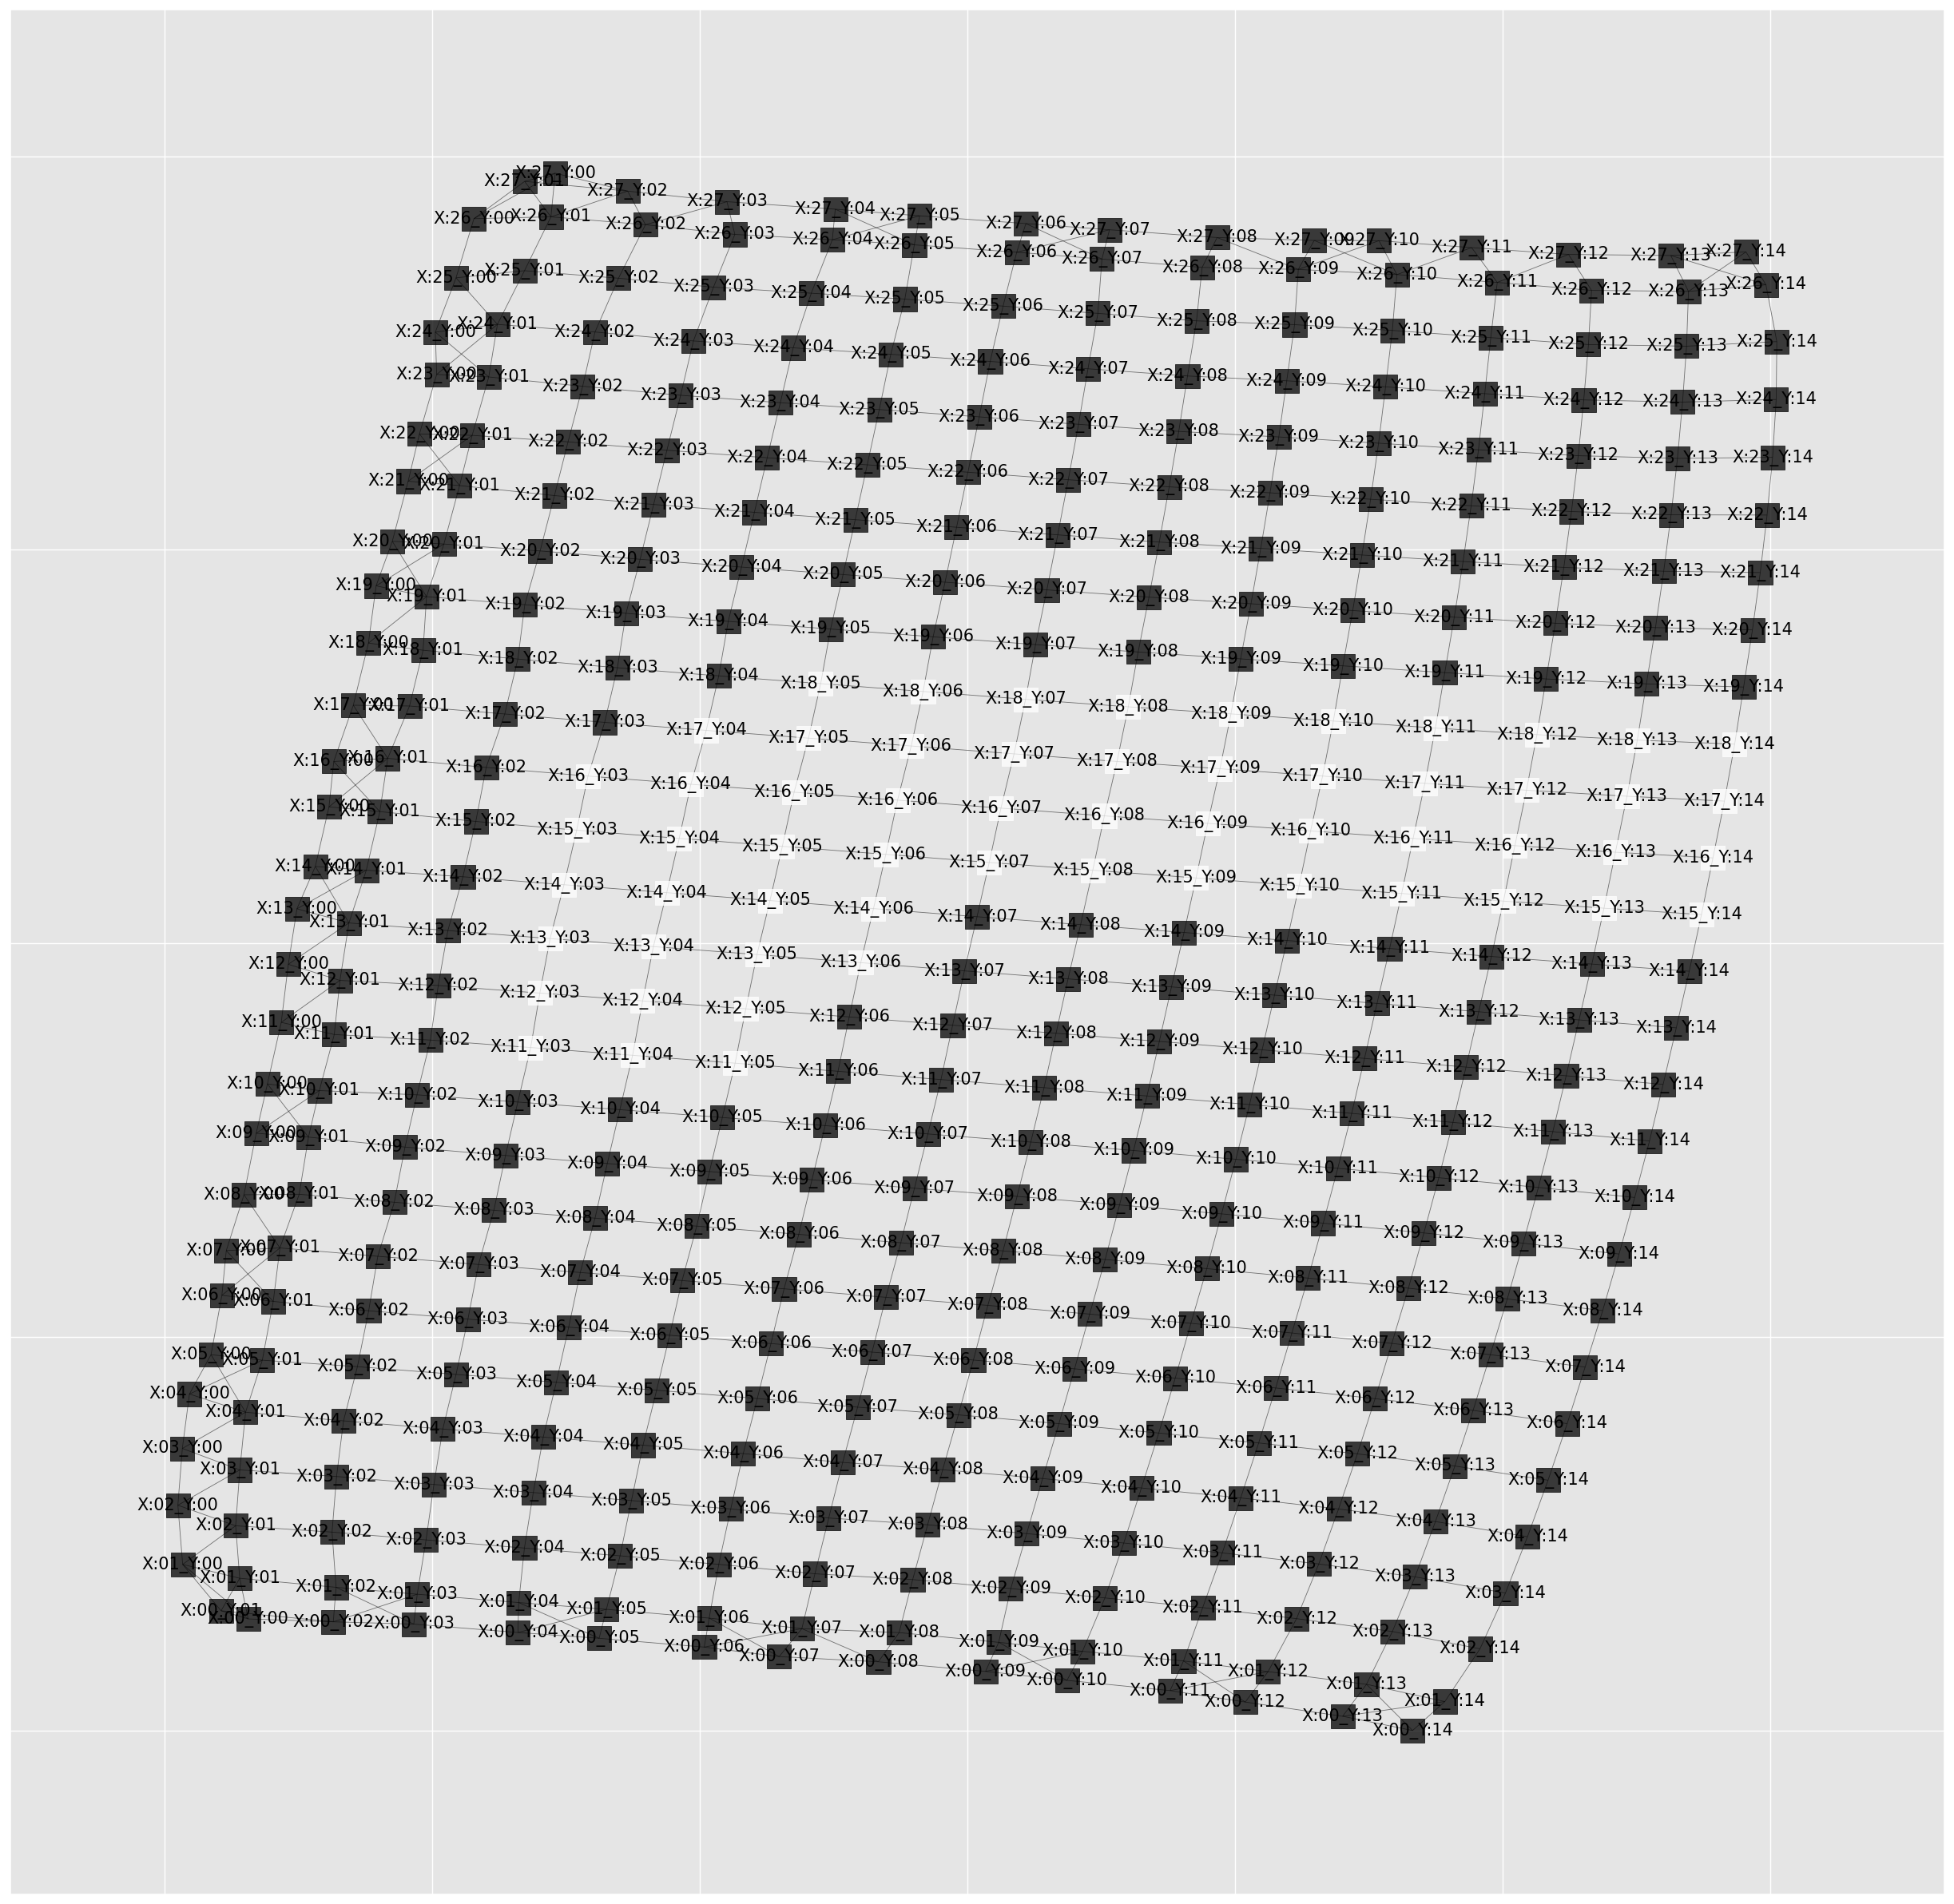

In [14]:
MAX_NODE = 28*15
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'white' if val > 0 else 'black'
draw_graph_mpl(G);
print(y_train[0])

2


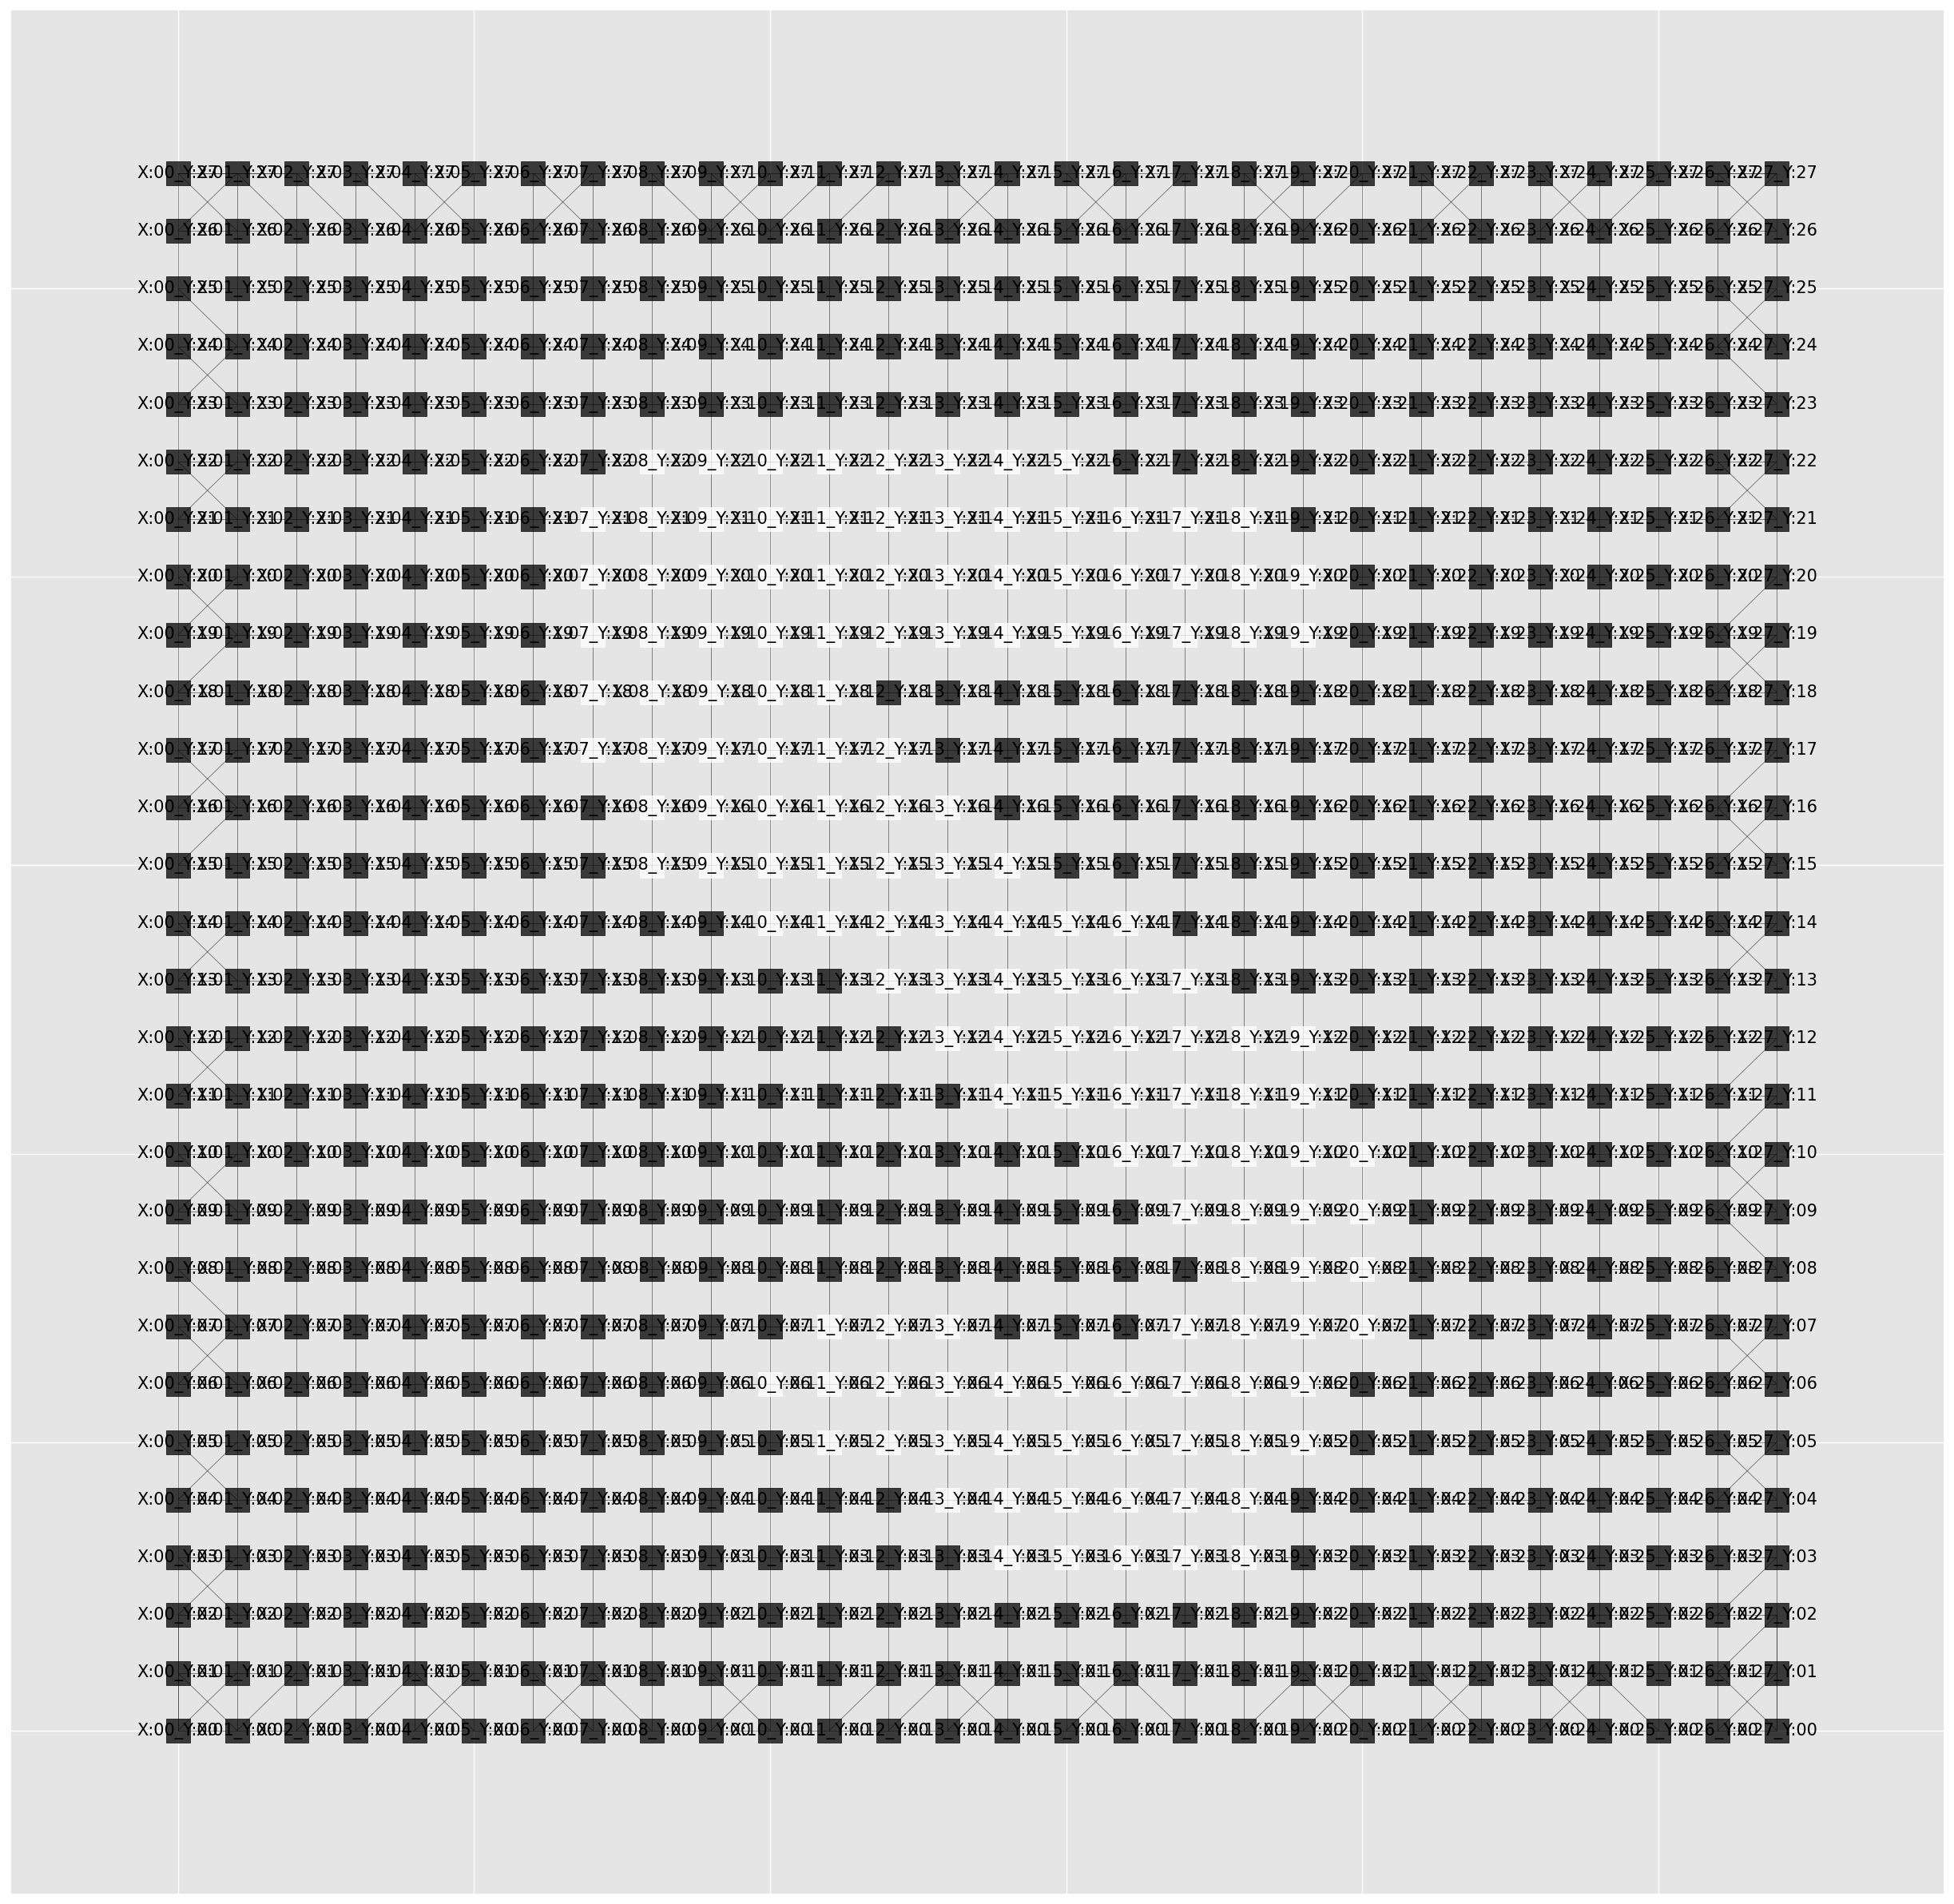

In [22]:
G = nx.from_scipy_sparse_matrix(adj)
for k, val in zip(G.nodes, X_train[10]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'white' if val>0 else 'black'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));
print(y_train[10])

### Create Edge Graph for Each Image

In [23]:
(X_train, y_train), (X_test, y_test) = m.load_data()

In [24]:
def _grid_coordinates_from_img(in_img, threshold):
    x = np.linspace(0, 1, in_img.shape[0], dtype=np.float32)
    y = np.linspace(0, 1, in_img.shape[1], dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.stack([
        xx[in_img>threshold].ravel(),
        yy[in_img>threshold].ravel(),
        in_img[in_img>threshold].ravel()
    ], -1)
    z = z[np.argsort(-z[:, 2]), :]
    return z

def _mnist_img_grid_graph(in_img, k, threshold=0.5):
    X = _grid_coordinates_from_img(in_img, threshold=threshold)
    A = _get_adj_from_data(X[:, :2], k, mode='distance', metric='euclidean', include_self=False)
    return A, X

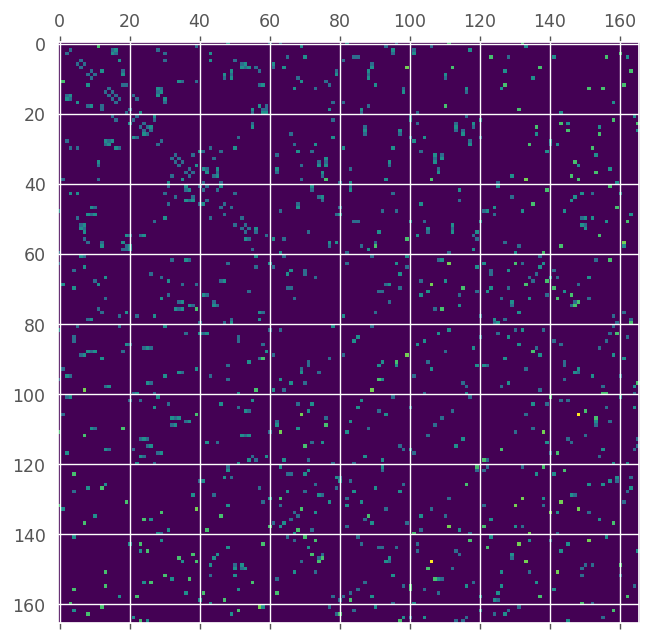

In [25]:
adj, vec = _mnist_img_grid_graph(X_train[0].reshape(28, 28), 6, threshold=0.0)
plt.matshow(adj.todense(), cmap='viridis')

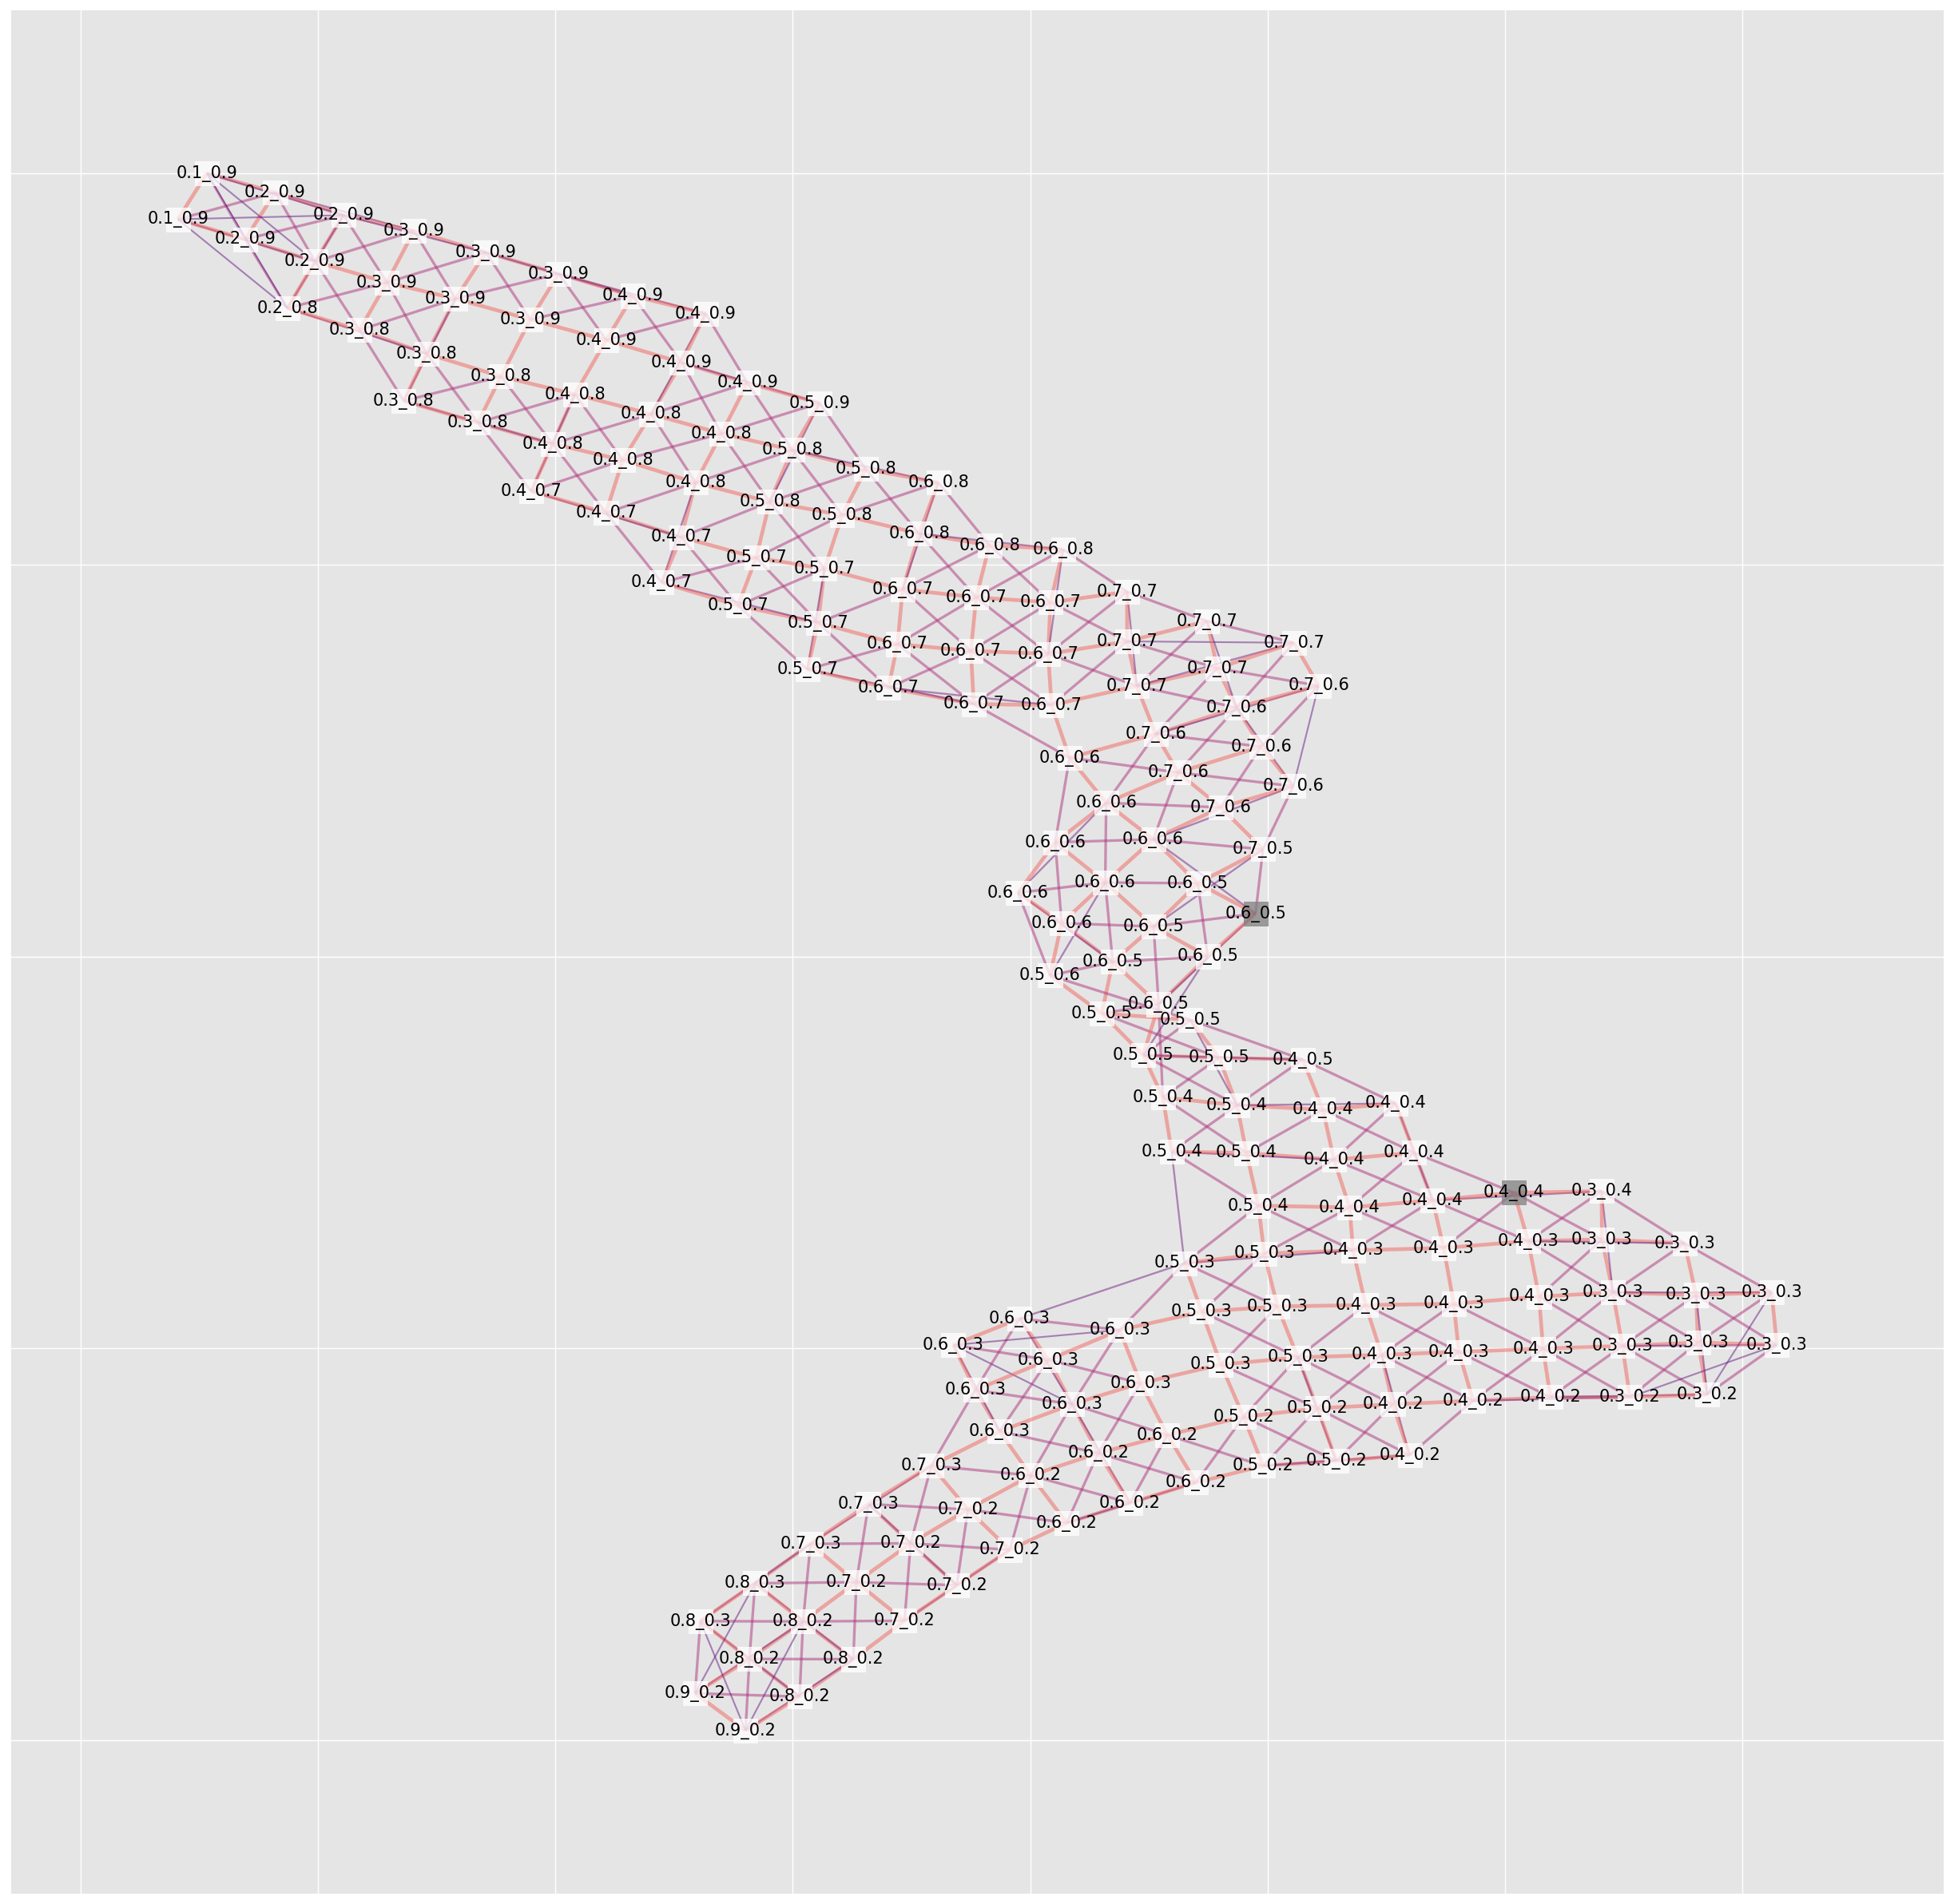

In [26]:
G = nx.from_scipy_sparse_matrix(adj)
for k, (xval, yval, cval) in zip(G.nodes, vec):
    G.nodes[k]['label'] = '{:2.1}_{:2.1}'.format(xval, yval)
    G.nodes[k]['color'] = plt.cm.gray(cval/2)
for e in G.edges():
    G.edges[e]['width'] = 0.1/G.edges[e]['weight']
    G.edges[e]['color'] = plt.cm.magma(0.025/G.edges[e]['weight'])
draw_graph_mpl(G);

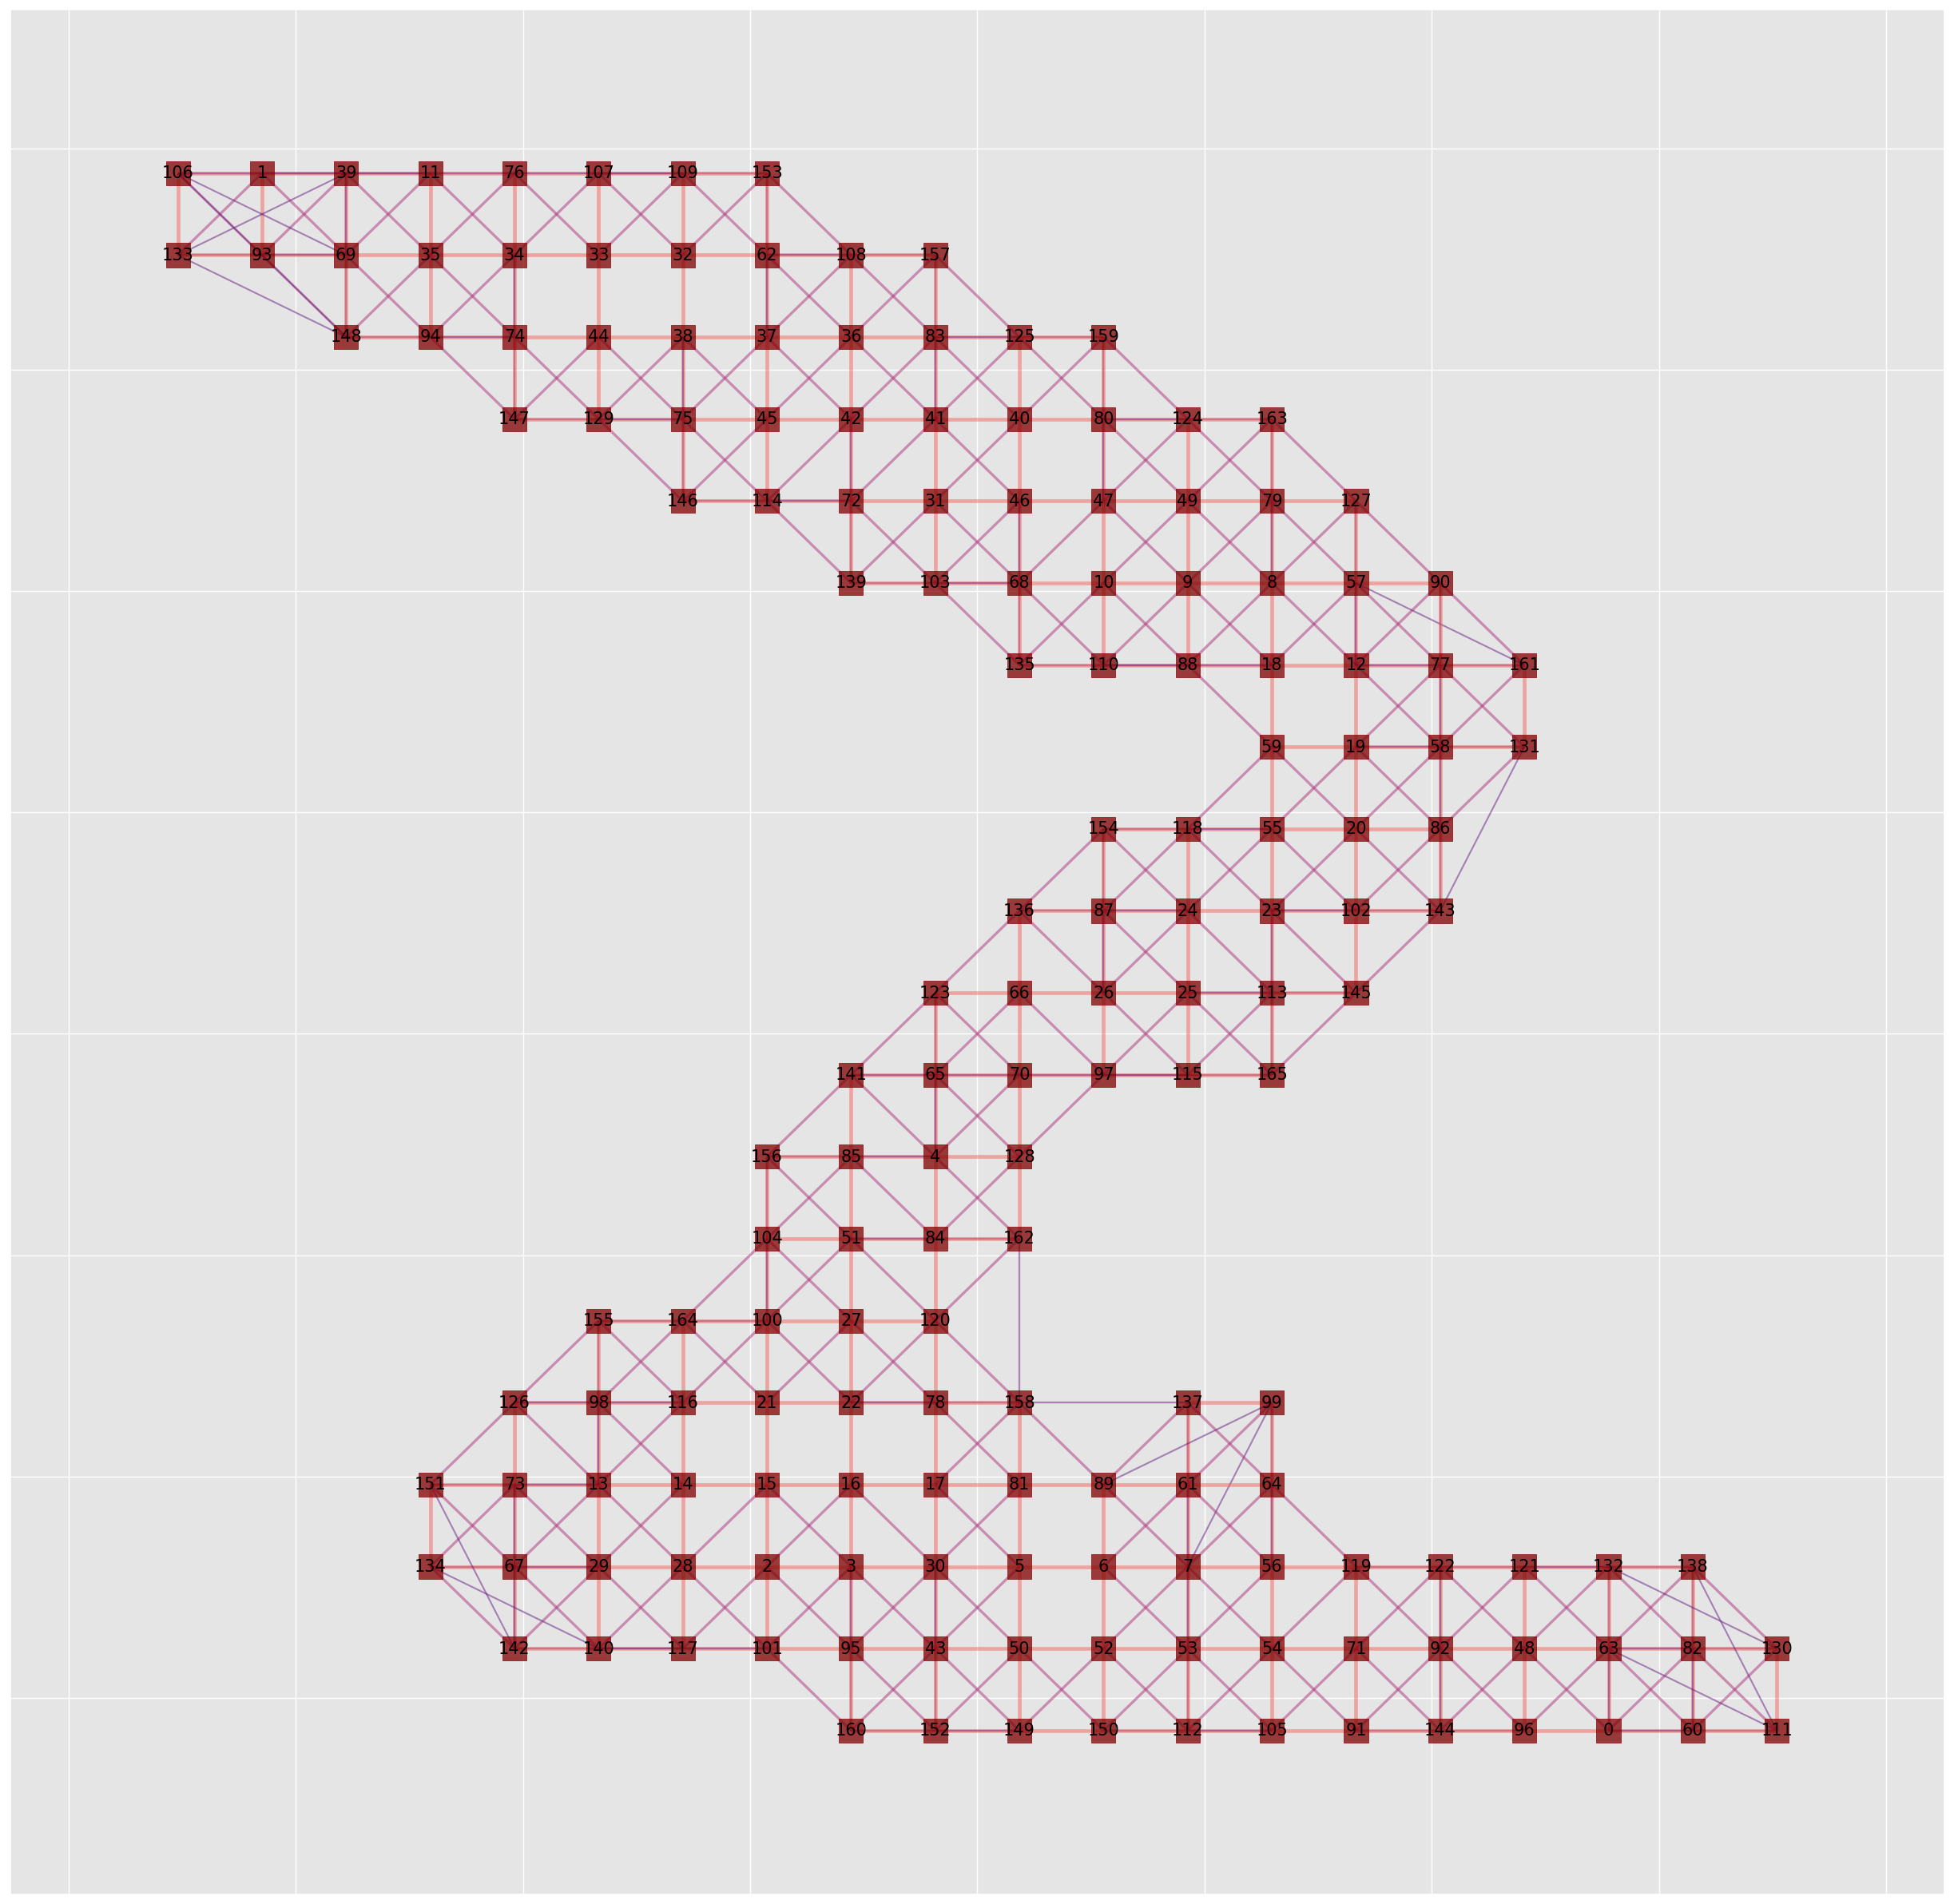

In [27]:
G = nx.from_scipy_sparse_matrix(adj)
for k, (xval, yval, cval) in zip(G.nodes, vec):
    G.nodes[k]['color'] = plt.cm.jet(cval)
for e in G.edges():
    G.edges[e]['width'] = 0.1/G.edges[e]['weight']
    G.edges[e]['color'] = plt.cm.magma(0.025/G.edges[e]['weight'])
draw_graph_mpl(G, pos=vec[:, :2]);